In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from os.path import join, expanduser, basename
import os
import geopandas as gpd
import rasterio as rio
from shapely.geometry import box
import matplotlib as mpl
from rasterio.features import dataset_features
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
import folium
from folium import plugins

from invert import invert_sd, epsilon_density
from rio_geom import 
from folium_vis import add_ee_layer
folium.Map.add_ee_layer = add_ee_layer


In [2]:
import ee

# Initialize the Earth Engine module.
ee.Initialize()

In [84]:
snow_cover.reduceRegion(**{'reducer': ee.Reducer.count(), 'scale' : 500}).getInfo()['NDSI_Snow_Cover']

KeyError: 'NDSI_Snow_Cover'

In [91]:
with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

for i in image_fps:
    # if i['fp'] == '/bsuscratch/zacharykeskinen/data/uavsar/images/Salt Lake City, UT/stlake_27129_21010-001_21011-012_0007d_s01_L090_01_int_grd/stlake_27129_21010-001_21011-012_0007d_s01_L090HH_01.unw.grd.tiff':
        if basename(i['fp']).split('_')[-2][-2:] == 'HH':
            try:
                fp = i['fp']
                with rio.open(fp) as src:
                    bounds = src.bounds
                geom = ee.Geometry.BBox(*bounds)
                df = pd.read_csv(i['ann'], index_col = [0])
                s = pd.to_datetime(df.loc['value','start time of acquisition for pass 1']).tz_localize(None)
                e = pd.to_datetime(df.loc['value','start time of acquisition for pass 2']).tz_localize(None)
                cor = i['cor']
                snow_cover = ee.ImageCollection("MODIS/006/MOD10A1").select('NDSI_Snow_Cover').filterDate(s,e).mean().clip(geom)
                sc_masked = snow_cover.updateMask(snow_cover.lte(0.1))
                mask_count = sc_masked.reduceRegion(**{'reducer': ee.Reducer.count(), 'scale' : 500}).getInfo()['NDSI_Snow_Cover']
                full_count = snow_cover.reduceRegion(**{'reducer': ee.Reducer.count(), 'scale' : 500}).getInfo()['NDSI_Snow_Cover']
                print(f'Pixels below 0.1 {mask_count/full_count} for total of {mask_count}')
            except ee.ee_exception.EEException as e:
                print(e)

Pixels below 0.1 2.685500980207858e-05 for total of 1
Pixels below 0.1 0.24426564188783476 for total of 6102
Pixels below 0.1 0.23677895298195717 for total of 7992
Pixels below 0.1 0.2103630664751208 for total of 6443
Pixels below 0.1 0.39440464005458886 for total of 13872
Pixels below 0.1 0.3357272256728778 for total of 10378
Pixels below 0.1 0.13772811425548798 for total of 2083
Pixels below 0.1 0.0010691613765452723 for total of 16
Pixels below 0.1 0.14466546112115733 for total of 2160
Pixels below 0.1 0.23835268989454012 for total of 3571
Pixels below 0.1 0.00026059763724808893 for total of 3
<class 'ee.ee_exception.EEException'>
Image.lte: If one image has no bands, the other must also have no bands. Got 0 and 1.
Pixels below 0.1 0.0002384358607534573 for total of 2
Pixels below 0.1 0.00016861984655593964 for total of 2
Pixels below 0.1 0.0018388690955062636 for total of 16
Pixels below 0.1 0.05638297872340425 for total of 1113
Pixels below 0.1 0.005342985177524991 for total of 62

KeyboardInterrupt: 

In [5]:
fp = '/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd/uticam_21003_21004-002_21013-003_0034d_s01_L090HH_01.unw.grd.tiff'
with rio.open(fp) as src:
    shapes = list(dataset_features(src, bidx=1, as_mask=False, geographic=True, band=False))
    result = gpd.GeoDataFrame.from_dict(shapes, crs = 'EPSG:4326')
    for i in result.index:
        result.iloc[i]['geometry'] = Polygon(result.iloc[i]['geometry']['coordinates'][0])
    boundary = gpd.GeoSeries(unary_union(result['geometry']))
    boundary_gdf = gpd.GeoDataFrame(boundary, columns = ['geometry'], crs = 'EPSG:4326')

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/geopandas/geodataframe.py:475: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  return GeoDataFrame(dataframe, geometry=geometry, crs=crs)


In [87]:
# Load an image.
image = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_044034_20140318')

# Define the visualization parameters.
image_viz_params = {
    'bands': ['NDSI_Snow_Cover'],
    'min': 0,
    'max': 1
}
loc = [geom._coordinates[0][0][1], geom._coordinates[0][0][0]]
# Define a map centered on San Francisco Bay.
map_l8 = folium.Map(location=loc, zoom_start=8)

# Mask the non-watery parts of the image, where NDWI < 0.4.
snow_cover_masked = snow_cover.updateMask(snow_cover.lte(0.1))
# Add the image layer to the map and display it.
map_l8.add_ee_layer(snow_cover.clip(geom), image_viz_params, 'false color composite')

# Add a layer control panel to the map.
map_l8.add_child(folium.LayerControl())


display(map_l8)


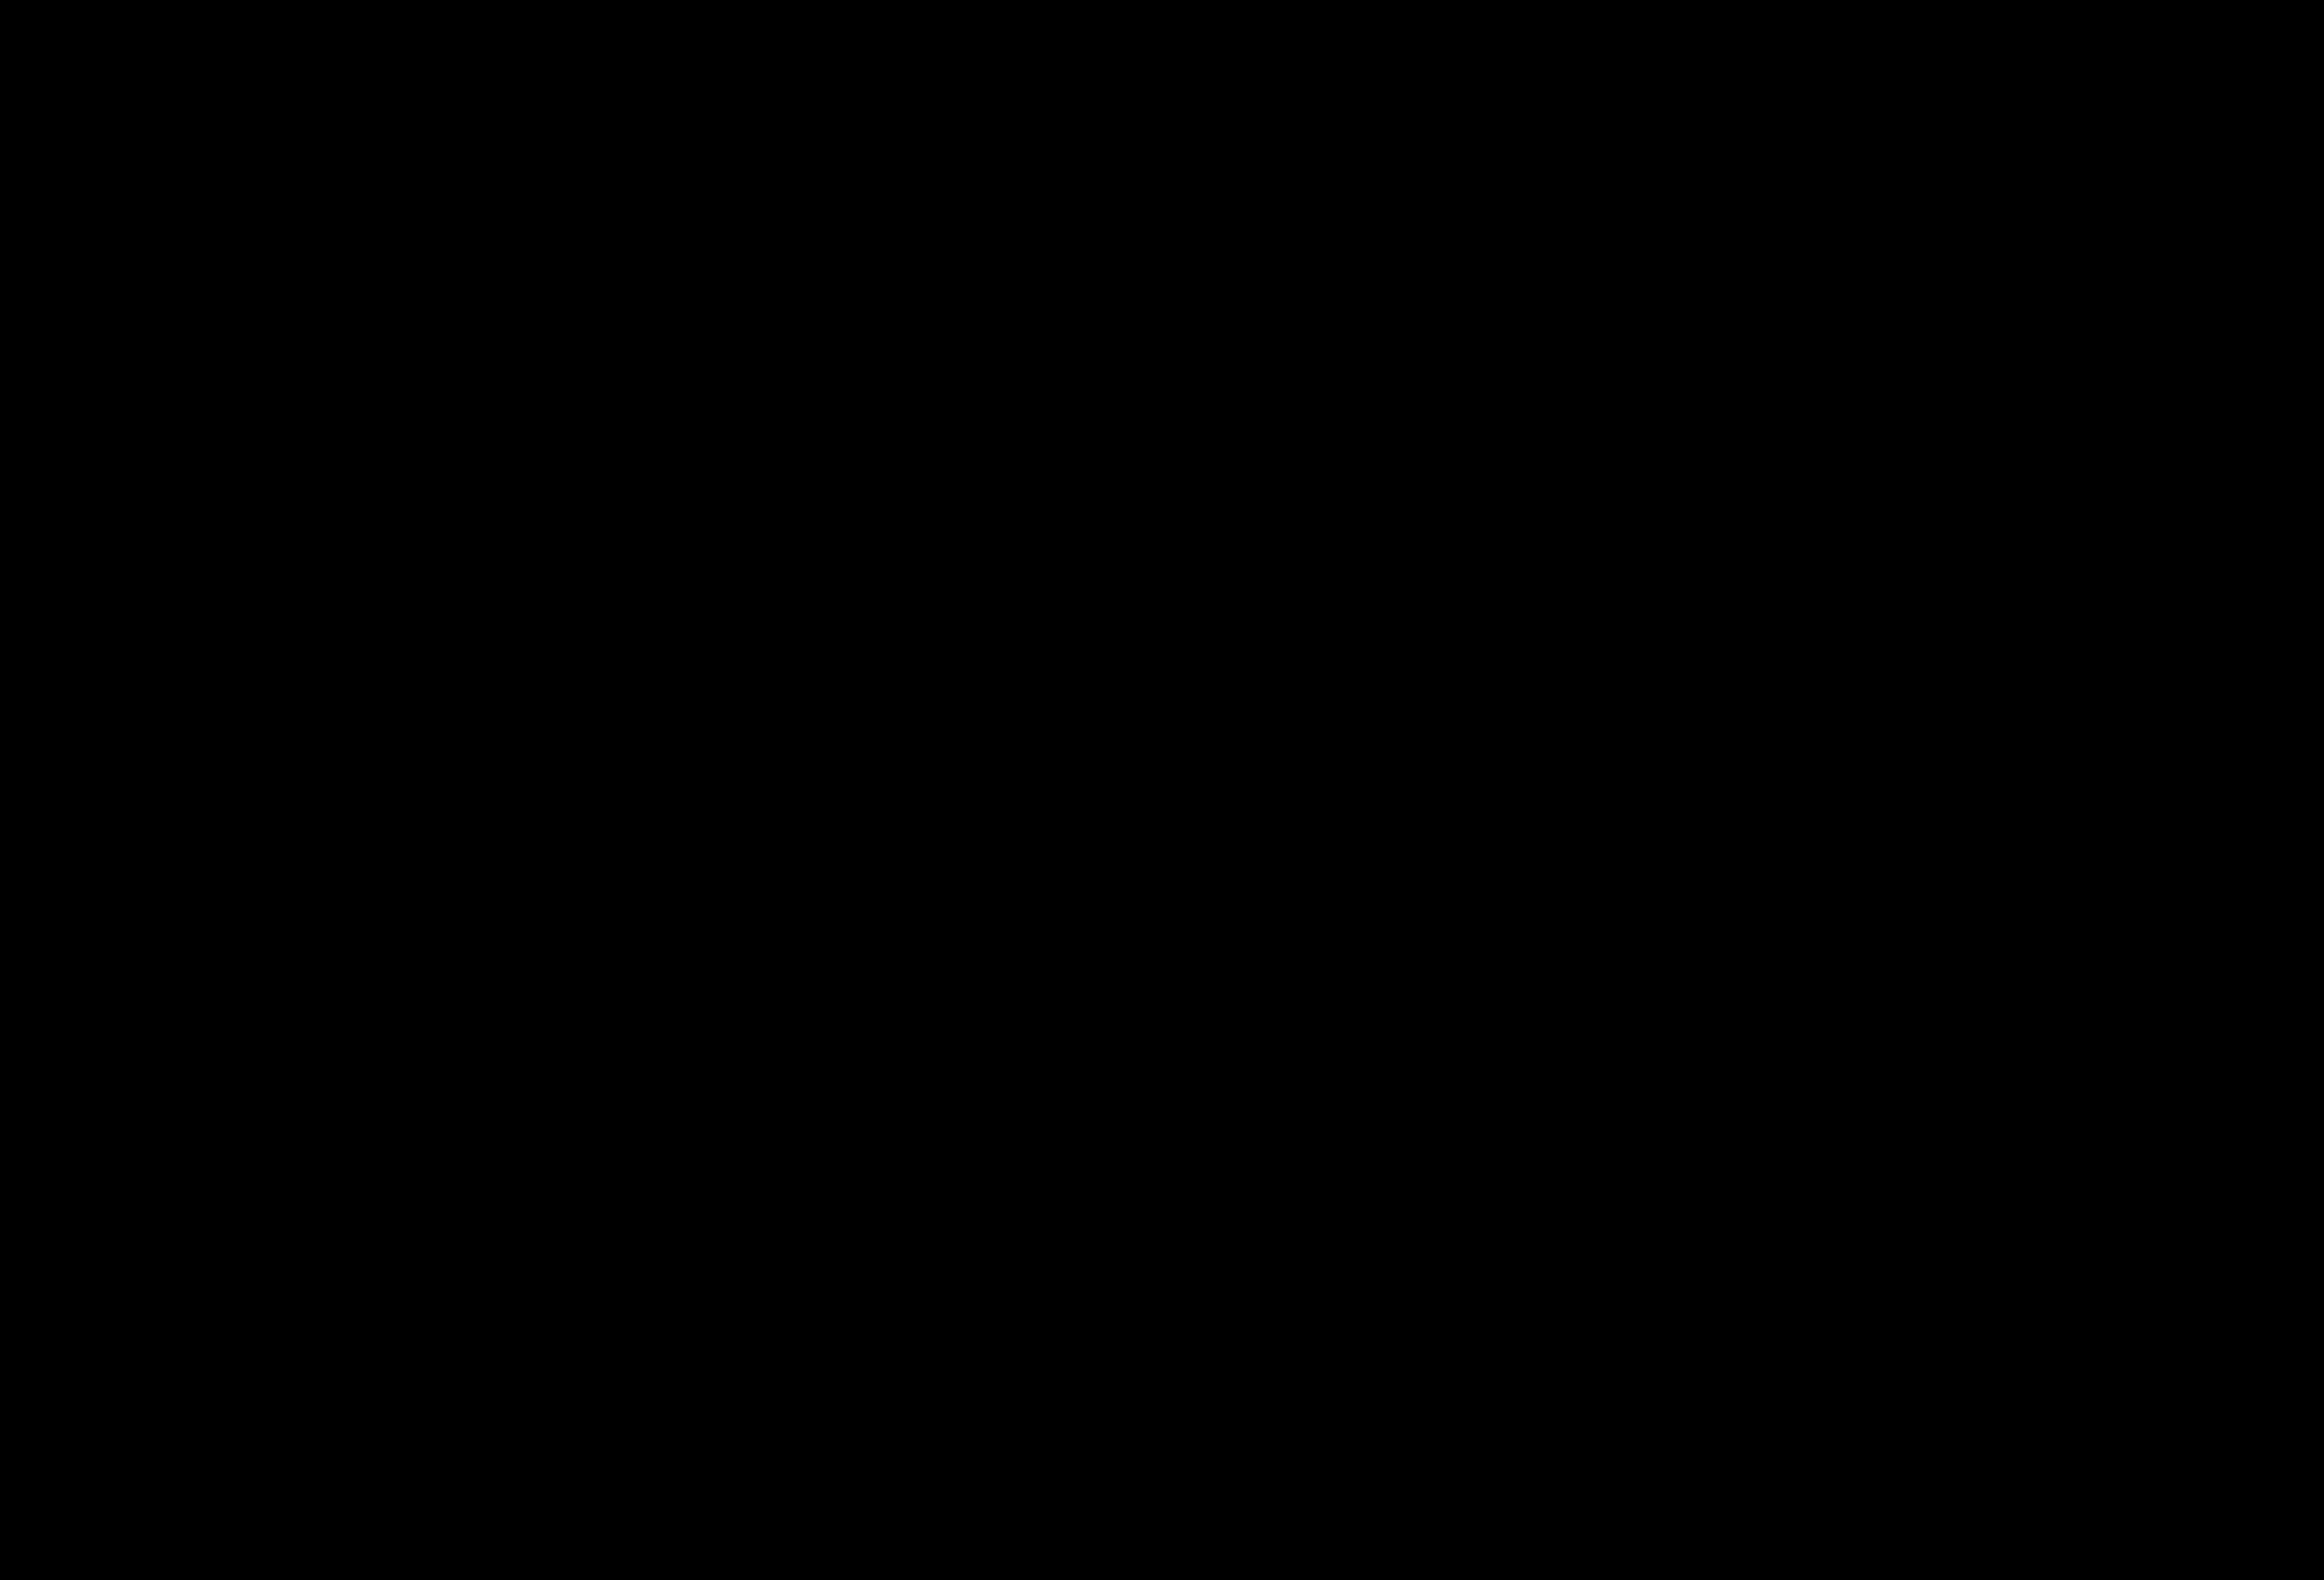

In [100]:
#Visualization in folium
map= folium.Map(location=[-112, 40], zoom_start=5,tiles='Stamen Terrain')
with rio.open(i['fp']) as src:
    data = src.read(1)
    folium.raster_layers.ImageOverlay(
        image=data,
        bounds=src.bounds
    ).add_to(map)

# Add a layer control panel to the map.
map.add_child(folium.LayerControl())
display(map)